## Récupération des données de consommation d'électricité et de températures

Dans ce fichier, nous récupérons les données de consommation d'électricité annuelle par département et les valeurs des températures moyennes annuelles par département. Nous mettons en forme les bases de données, dans le but de pouvoir les réutiliser dans la partie modélisation et procédons à une analhyse descriptive non exhaustive des données récupérées. 
Nos données étant avant tout géographiques, nous choisissons de les visualiser avant tout sous forme de carte. 

In [ ]:
!pip install pandas
!pip install geopandas
!pip install lxml
!pip install urllib
!pip install matplotlib
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a
!pip install mapclassify
!pip install folium

In [1]:
import importlib
import pandas as pd
import requests
import geopandas as gpd
import declarations_AV as dec
import matplotlib.pyplot as plt
import mapclassify as mc
import folium
import os
from os.path import isfile
import json

Notre travail se décompose en deux études à des échelles différentes. Nous nous sommes d'abord donnés pour but d'essayer de prédire la consommation d'électricité du secteur résidentiel en fonction des données météo à l'échelle des départements français.\
En effet, grâce aux données disponibles sur le site de l'Agence ORE (Opérateurs des Réseaux d'Energie), nous récupérons les données de consommation d'électricté du secteur résidentiel à l'échelle des départements pour les années 2011 à 2021. De plus, nous récupérons via l'API "<i>Température quotidienne départementale depuis janvier 2018</i>" d'Open Data Réseaux Energie (ODRE) les températures moyennes, minimales et maximales par département.\
La deuxième partie de notre travail sera consacrée, si nous avons le temps, à une régression de la consommation d'électricté sur des variables additionnelles, notamment les Diagnostics de Performance Energétique (DPE), auxquels nous avons uniquement accès par adresse. Nous nous restreindrons alors uniquement aux communes pour lesquelles nous avons aussi pu webscrapper des données météo. 


#### 1- Récupération et analyse descriptive des données de consommation annuelle d'électricité par département et par secteur d'activité

Les données que nous récupérons dans cette partie sont disponibles en Open Data sur le site de l'Agence ORE (Opérateur des Réseaux d'Energie). Plus précisément, le jeu de données que nous utilisons est intitulé "Consommation annuelle d'électricité et gaz par département et par secteur d'activité" et existe pour les années de 2011 à 2021. Nous ne considérons que la consommation d'électricité du secteur résidentiel. De plus, nous nous restreignons aux départements de France métropolitaine uniquement.

In [2]:
# Base de données provenant du site de l'Agence ORE
df_cons_département=pd.read_csv(dec.cons_département, sep=";")

# Sélection des départements de métropole uniquement
df_cons_département=df_cons_département.loc[~df_cons_département['Code Département'].isin(['971', '972', '973', '974', '975','976'])]

In [3]:
df_cons_département.columns

Index(['Opérateur', 'Année', 'Filière', 'Consommation Agriculture (MWh)',
       'Nombre de points Agriculture',
       'Nombre de mailles secretisées (agriculture)',
       'Indique qualité Agriculture', 'Consommation Industrie (MWh)',
       'Nombre de points Industrie',
       'Nombre de mailles secretisées (industrie)', 'Indice qualité Industrie',
       'Consommation Tertiaire  (MWh)', 'Nombre de points Tertiaire',
       'Nombre de mailles secretisées (tertiaire)', 'Indice qualité Tertiaire',
       'Consommation Résidentiel  (MWh)', 'Nombre de points Résidentiel',
       'Nombre de mailles secretisées (résidentiel)',
       'Indice qualité Résidentiel', 'Consommation Secteur Inconnu (MWh)',
       'Nombre de points Secteur Inconnu',
       'Nombre de mailles secretisées (secteur inconnu)',
       'Indice qualité Non Affecté', 'Code Département', 'Libellé Département',
       'Code Région', 'Libellé Région', 'id_filiere', 'geom',
       'Consommation totale (MWh)'],
      dtype='

In [4]:
# Sélection des variables auxquelles nous nous intéressons
variables_cons_département= ['Opérateur', 'Année', 'Filière', 
                             'Consommation Résidentiel  (MWh)', 'Nombre de points Résidentiel', 
                             'Nombre de mailles secretisées (résidentiel)','Indice qualité Résidentiel',
                             'Code Département', 'Libellé Département','Code Région', 'Libellé Région', 
                             'id_filiere','Consommation totale (MWh)']
liste_département=pd.unique(df_cons_département["Libellé Département"])

In [ ]:
# Récupération du nombre d'habitants par département 
df_pop=pd.read_json('data_pop.json')
dico_df_pop={}
for annee in range (2011,2021):
    df=pd.DataFrame(df_pop[annee])
    df['Code Département']=df.index
    df=df.loc[~df['Code Département'].isin(['971', '972', '973', '974', '975','976'])]
    df=df.rename(columns={annee:'Population'})
    dico_df_pop[annee]=df

In [6]:
dico_df_pop[2018].head(3)

,Population,Code Département
01,647634,01
02,533316,02
03,337171,03


In [7]:
list_années=range(2011,2021)
# Dictionnaire qui à chaque année associe le dataframe de consommation d'électricité 
# résidentielle par départements :
dico_cons_département={} 
# Dictionnaire qui à chaque année associe le dataframe contenant uniquement : 
# consommation totale d'électricité et code département :
dico_df_cons_tot={}
# Dictionnaire qui à chaque année associe la valeur de la consommation totale d'électricité du secteur
# résidentiel en France : 
dico_cons_tot={} 
for année in list_années:
    if année not in dico_cons_département.keys():
        df_année=dec.get_data_consumption_department(df_cons_département, année)
        dico_cons_département[année]=dec.df_filter(df_année, variables_cons_département) # On sélectionne les variables dont on a besoin
        df_cons_tot=dico_cons_département[année].groupby(["Code Département","Libellé Département"])['Consommation Résidentiel  (MWh)'].sum().reset_index()
        df_cons_tot=df_cons_tot.merge(dico_df_pop[année], how='left', on='Code Département')
        df_cons_tot['Consommation Résidentiel par habitant (MWh)']=round(df_cons_tot['Consommation Résidentiel  (MWh)']/df_cons_tot['Population'],3)
        dico_df_cons_tot[année]=df_cons_tot
        dico_cons_tot[année]=df_cons_tot['Consommation Résidentiel  (MWh)'].sum()


Premier aperçu de la base de données après sélection des variables d'intérêt : 

In [8]:
dico_cons_département[2020].head(3)

,Opérateur,Année,Filière,Consommation Résidentiel (MWh),Nombre de points Résidentiel,Nombre de mailles secretisées (résidentiel),Indice qualité Résidentiel,Code Département,Libellé Département,Code Région,Libellé Région,id_filiere,Consommation totale (MWh)
1525,Arc Energies Maurienne,2020,Electricité,13374.0,2437,0,0.0,73,Savoie,84,Auvergne-Rhône-Alpes,100,24626.000
1526,Coopérative d'électricité de Saint Martin de L...,2020,Electricité,231966.0,36035,6,1.0,34,Hérault,76,Occitanie,100,363965.000
1527,EdF-SEI,2020,Electricité,0.0,0,0,0.0,29,Finistère,53,Bretagne,100,699.891


In [9]:
dico_df_cons_tot[2020].head(3)

,Code Département,Libellé Département,Consommation Résidentiel (MWh),Population,Consommation Résidentiel par habitant (MWh)
0,01,Ain,1.805527e+06,657856,2.745
1,02,Aisne,1.281305e+06,529374,2.420
2,03,Allier,8.808159e+05,335628,2.624


In [9]:
# Création d'un GeoDataFrame des départements français
departements=dec.df_filter(dec.dep, dec.var_dep)
departements=gpd.GeoDataFrame(departements, geometry=departements['geometry'])
departements_json=departements.to_json()

In [10]:
# Dictionnaire de GeoDataFrame alliant les données de "departements" et les données des dataframes de consommation
# pour chaque année.
dico_carte={}
for annee in list_années:
    dico_carte[annee]=gpd.GeoDataFrame(dico_df_cons_tot[annee].merge(departements, left_on='Code Département',
                                                    right_on='INSEE_DEP', how='left'))
    dico_carte[annee].drop('INSEE_DEP', axis='columns')

# Fonction permettant de remplacer les chiffres de la légende par les valeurs des intervalles
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)


In [ ]:
# On trace la carte
replace=False
for annee in [2018,2019,2020]:
    q5=mc.Quantiles(dico_carte[annee]['Consommation Résidentiel par habitant (MWh)'], k=5)
    mapping=dict([(i, s) for i, s in enumerate(q5.get_legend_classes())])
    ax = dico_carte[annee].plot(
        column=q5.yb,
        categorical=True,
        k=5,
        cmap="OrRd",
        linewidth=0.1,
        edgecolor="black",
        legend=True,
        legend_kwds=dict(loc='lower left',
                                bbox_to_anchor=(1, .5),
                                fontsize='small',
                                title="Consommation Résidentiel par Habitant en "+f"{annee} (MWh)",
                                frameon=False),
    )
    
    ax.set_axis_off()
    replace_legend_items(ax.get_legend(), mapping)
    path_to_file='cartes\conso_'+f"{annee}.png"
    
    if not (isfile (path_to_file) and not replace):
        plt.savefig(path_to_file, bbox_inches='tight', pad_inches=0.1) # On enregistre les cartes dans le dossier associé

On représente à présent l'évolution de la consommation d'énergie du résidentiel entre 2011 et 2021 :

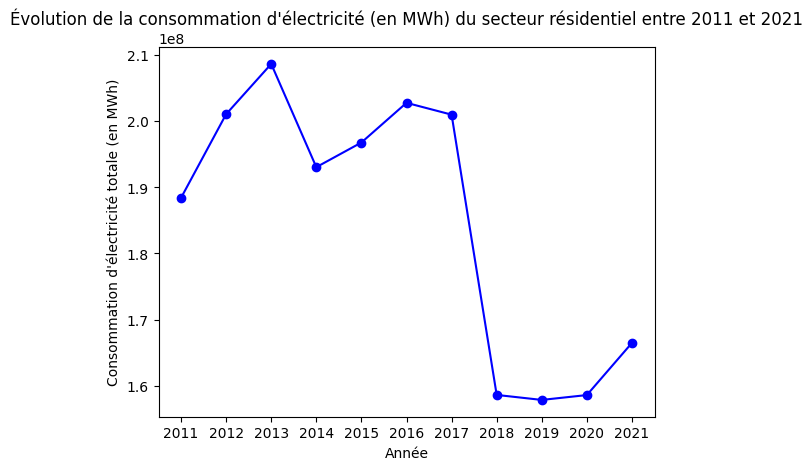

In [12]:
conso_par_an=list(dico_cons_tot.values())
plt.plot(list_années, conso_par_an, marker='o', linestyle='-', color='b')
plt.title("Évolution de la consommation d'électricité (en MWh) du secteur résidentiel entre 2011 et 2021")
plt.xlabel('Année')
plt.ylabel("Consommation d'électricité totale (en MWh)")
plt.xticks(list_années)
plt.show()

Entre 2011 et 2021 la consommation d'électricité totale du secteur résidentiel en France métropolitaine a fortement varié. En particulier, on observe une chute de la consommation du secteur résidentiel entre 2017 et 2018, sa valeur passant de plus de 2x10^8 MWh à 1.6x10^8 MWh. La valeur de la consommation est demeurée stable entre 2018 et 2020 et a amorcé une réaugmentation en 2021.\
Nous ne nous intéresserons cependant pas dans notre projet à l'évolution temporelle de la consommation.

### 2- Récupération des données de températures annuelles à l'échelle des départements

Il s'agit à présent de récupérer les températures moyennes annuelles par département pour au moins l'une des années pour lesquelles nous avons des données de consommation. Pour cela nous avons trouvé le jeu de données disponible en Open Data sur le site de l'ODRE, donnant les températures quotidiennes départementales depuis janvier 2018.\
La manière la plus efficace d'obtenir des températures moyennes annuelles (et minimales et maximales puisqu'elles sont aussi à disposition) par département est d'utiliser l'API en effectuant directement la requête adaptée. Dans le cas des températures moyennes, on utilise `group_by(code_insee_departement)` avec `select(avg(tmoy))`.

In [11]:
# Création d'un dictionnaire qui à chaque année associe un dataframe contenant la température moyenne,
# la température minimale et la température maximale enregistrées par département
dico_df_temp={}
for année in [2018,2019,2020,2021]:
    df_tmoy=dec.get_data_from_api(dec.api_root_temp, dec.api_req_tmoy, année)
    df_tmin=dec.get_data_from_api(dec.api_root_temp, dec.api_req_tmin, année)
    df_tmax=dec.get_data_from_api(dec.api_root_temp, dec.api_req_tmax, année)
    res=df_tmax.merge(df_tmin, on='code_insee_departement',how='left')
    df_temp=df_tmoy.merge(res, on='code_insee_departement', how='left')
    df_temp.rename(columns={'avg(tmoy)':'tmoy', 'max(tmax)':'tmax', 'min(tmin)':'tmin'}, inplace=True)
    df_temp=df_temp.drop(['departement_x','departement_y'],axis='columns')
    dico_df_temp[année]=df_temp

On visualise le dataframe obtenu avec les températures : 

In [16]:
dico_df_temp[2020].head(3)

,code_insee_departement,departement,tmoy,tmax,tmin
0,01,Ain,12.769262,38.9,-5.3
1,02,Aisne,12.189617,37.9,-4.7
2,03,Allier,13.042760,40.2,-6.3


In [ ]:
# Fonction permettant d'ajouter le bon argument 'Légende' au dataframe 'departements', dans le but d'ajouter des
# étiquettes à la carte folium créée par la suite.

def f(df, gdf):
    '''Ajoute une colonne 'Legende' au GeoDataFrame 'departements', en prenant les valeurs de températures 
    moyennes, minimales et maximales pour un DataFrame du dictionnaire 'dico_df_temp'.
    Entrées:
            df (DataFrame) : dans cette fonction un des DataFrames de 'dico_df_temp'
            gdf (GeoDataFrame) : dans cette fonction le GeoDataFrame 'departements'
    Sortie:
            new_df (GeoDataFrame) : 'departements' auquel a été ajoutée une colonne 'Légende
    '''
    new_df=gdf
    new_df['Legende']=[0 for ligne in new_df.iterrows()]
    for code_dep in new_df['INSEE_DEP']:
        nom_dep=new_df.loc[new_df['INSEE_DEP'] == code_dep, 'NOM'].iloc[0]
        t_moy=df.loc[df['code_insee_departement']== code_dep,'tmoy'].iloc[0]
        t_min=df.loc[df['code_insee_departement']== code_dep,'tmin'].iloc[0]
        t_max=df.loc[df['code_insee_departement']== code_dep,'tmax'].iloc[0]
        new_df['Legende'][new_df['INSEE_DEP'] == code_dep]=f'{nom_dep} : tmoy={round(t_moy)}°C ; tmin={round(t_min)}°C ; tmax={round(t_max)}°C'
    return new_df

dep_2020=f(dico_df_temp[2020],departements)

In [ ]:
# Carte des températures moyennes
center_latitude = departements['geometry'].centroid.y.mean()
center_longitude = departements['geometry'].centroid.x.mean()

m = folium.Map(location=[center_latitude, center_longitude], zoom_start=5, tiles='cartodbpositron')

chloropleth_temp=folium.Choropleth(geo_data=dep_2020,
    data=dico_df_temp[2020],
    columns=['code_insee_departement','tmoy'],
    fill_color="OrRd",  # Colormap
    key_on='feature.properties.INSEE_DEP',
    fill_opacity=0.7,
    legend_name='Température moyenne (°C)',  # Nom de la légende
    highlight=True,
    nan_fill_color='blue',  # Couleur pour les valeurs manquantes
)
chloropleth_temp.geojson.add_child(
    folium.features.GeoJsonTooltip(['Legende'],labels=False))
chloropleth_temp.add_to(m)
display(m)

La carte obtenue montre des températures moyennes élevées dans le Sud-Ouest de la France, sur la côte Atlantique, ainsi que dans les départements situés sur la côte méditerranéenne. Ces températures sont supérieures à 15°C et atteignent jusqu'à 18°C de moyenne en Haute Corse. Dans le reste des départements de France métropolitaine, les températures moyennes en 2020 avoisinent les 13°C. Les départements les plus froids sont la Lozère, la Haute-Savoie, les Ardennes et la Haute Loire, avec des températures annuelles moyennes de 11°C et 10°C.

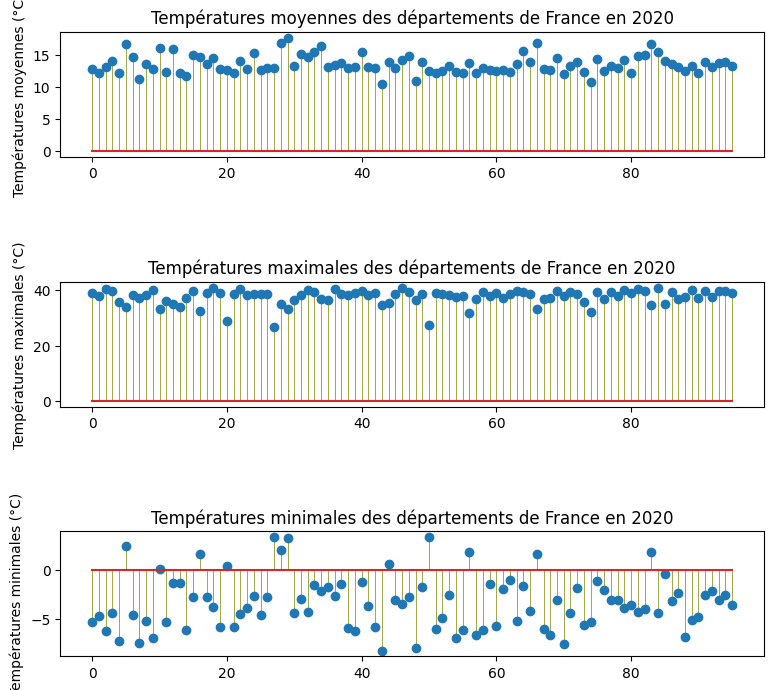

In [45]:
# Distributions des températures moyennes, minimales et maximales en 2020
plt.subplot(3,1,1)
(markers, stemlines, baseline) = plt.stem(dico_df_temp[2020]['tmoy']) 
plt.setp(stemlines, linestyle="-", color="olive", linewidth=0.5 )
plt.title('Températures moyennes des départements de France en 2020')
plt.ylabel('Températures moyennes (°C)')

plt.subplot(3,1,2)
(markers1, stemlines1, baseline1) = plt.stem(dico_df_temp[2020]['tmax'])
plt.setp(stemlines1, linestyle="-", color="olive", linewidth=0.5 )
plt.title('Températures maximales des départements de France en 2020')
plt.ylabel('Températures maximales (°C)')

plt.subplot(3,1,3)
(markers2, stemlines2, baseline2) = plt.stem(dico_df_temp[2020]['tmin'])
plt.setp(stemlines2, linestyle="-", color="olive", linewidth=0.5 )
plt.title('Températures minimales des départements de France en 2020')
plt.ylabel('Températures minimales (°C)')

plt.tight_layout()
plt.subplots_adjust(top=1.4, bottom=0.1, left=0.1, right=1.2, hspace=1., wspace=2)
plt.show()

### 4- Téléchargement des données de consommation d'électricité annuelle par adresse

Nous chargeons dans cette partie les données de consommation d'électricité par adresse. 

In [ ]:
df_cons_2018=dec.get_data_consumption(dec.consumption_data_url_2018, "2018")
df_cons_2019=dec.get_data_consumption(dec.consumption_data_url_2019, "2019")
df_cons_2020=dec.get_data_consumption(dec.consumption_data_url_2020, "2020")
df_cons_2021=dec.get_data_consumption(dec.consumption_data_url_2021, "2021")